In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
env = gym.make("FrozenLake-v0", map_name='4x4', is_slippery=False)

W srodowisku FrozenLake **stany** reprezentowane są za pomocą cyfr **0,1,2,...,15**. Na wejście sieci możemy podać **tensor o kształcie (1,16)**. W związku z tym musimy przekszatałcić stany do odpowieniej postaci. Robimy to w sposób opisany poniżej.

Wykorzystamy **macierz jednostkową o wymiarach 16x16**:

In [ ]:
np.identity(16)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
state = 0 #dowolna wartość 0,1,2,...,15
state = np.identity(16)[state]
state

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Wiersze z powyższej macierzy po **zmianie kształtu na (1,16)** będą odpowiednią reprezentacją **stanu**:

In [ ]:
state = state.reshape(1,16)
state

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Sień neuronowa **aproksymująca funkcję Q** na wejściu otrzymuje **tensor o kształcie (1,16)**. UWAGA: neurony w warstwie wyjściowej mają **funkcję aktywacji f(x)=x** (DLACZEGO?):

In [ ]:
model = Sequential()
model.add(Dense(units = 50, input_dim=16, activation='relu'))
model.add(Dense(units = 50, activation = "relu"))
model.add(Dense(units = 4, activation = "linear"))

Na wyjściu sieć **zwraca tensor o kształcie (1,4)**. Każda z czterech wartości to wartość **Q** dla stanu **s** i **każdej z możliwych akcji** (0-lewo,1-dół,2-prawo,3-góra):

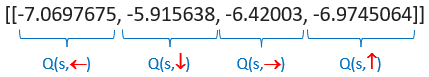

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#opt = keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='MSE',optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                850       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 3,604
Trainable params: 3,604
Non-trainable params: 0
_________________________________________________________________


Parametry uczenia:

In [ ]:
train_episodes = 100
epsilon = 0.5
gamma = 0.99

In [ ]:
epsilon = 1 

Pętla treningowa:

In [ ]:
Loss = []
Rewards = []
for e in range(train_episodes):
  
  total_reward = 0
  t = 0
  #epsilon zmieniany po kazdyn epizodzie
  #epsilon = epsilon - (1/train_episodes)

  state = env.reset()
  state = np.identity(16)[state]
  state = np.reshape(state,[1,16])  

  done = False
  while done == False:
    
    Qs = model.predict(state)[0]

    if np.random.rand()<epsilon:
      action = env.action_space.sample()
    else:
      action = np.argmax(Qs)
    
    next_state, reward, done, _ = env.step(action)

    if done:
      if reward == 1:
        reward = 5
      else:
        reward = -5
    else:
      reward = -1

    next_state = np.identity(16)[next_state]
    next_state = np.reshape(next_state, [1, 16])

    Qs_next = model.predict(next_state)[0]

    Qs = np.reshape(Qs,[1,4])    
  
    Qs_target = np.copy(Qs)

 
    if done:
      y = reward
    else:
      y = reward + gamma*np.max(Qs_next)

    Qs_target[0][action] = y


    h = model.fit(state,Qs_target,epochs=1,verbose=0)

  
    loss = h.history['loss'][0]

    state = next_state
    total_reward += reward
    t+=1
  
  if e%10==0:
    print("R=",total_reward," L=",loss)
  
  Rewards.append(total_reward)
  Loss.append(loss)

R= -11  L= 6.301435947418213
R= -7  L= 5.60468053817749
R= -6  L= 4.746326446533203
R= -12  L= 2.401430130004883
R= -6  L= 0.41784432530403137
R= -13  L= 0.6887457370758057
R= -14  L= 0.17159783840179443
R= -8  L= 0.05547354742884636
R= -19  L= 0.08723870664834976
R= -7  L= 0.05927401781082153


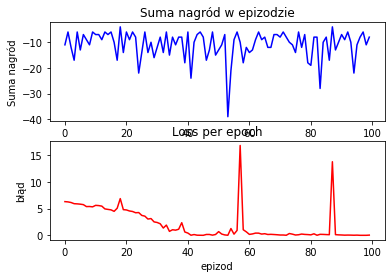

In [ ]:
plt.subplot(211)
plt.ylabel('Suma nagród')  
plt.title('Suma nagród w epizodzie')
plt.plot(list(range(train_episodes)),Rewards,"b")

plt.subplot(212)
plt.xlabel('epizod')
plt.ylabel('błąd')  
plt.title('Loss per epoch')
plt.plot(list(range(train_episodes)),Loss,"r")

plt.show()